In [83]:
import torch
from torch import nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_from_disk
from tqdm import tqdm 
import pandas as pd

In [62]:
dataset = load_from_disk("resized_oxford_pets_224")

In [84]:
# Step 1: Create the base model
resnet = models.resnet18(pretrained=False)  
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 37)  # 37 breeds in the Oxford-IIIT Pet dataset

# Step 2: Load the trained weights
state_dict = torch.load("trained_models/resnet.pt", map_location='cpu')
resnet.load_state_dict(state_dict)
resnet.eval()


/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Imagenet mean
        std=[0.229, 0.224, 0.225]    # Imagenet std
    ),
])


img = dataset['train'][0]['image']
# input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

In [85]:
def resnet_generate_gradcam(model, img):
    input_tensor = transform(img).unsqueeze(0)
    target_layer = model.layer4[-1]
    cam = GradCAM(model=model, target_layers=[target_layer])
    outputs = model(input_tensor)
    pred_class = outputs.argmax().item()
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0, :]
    img_np = np.array(img.resize((224, 224))).astype(np.float32) / 255
    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    return cam_image, pred_class

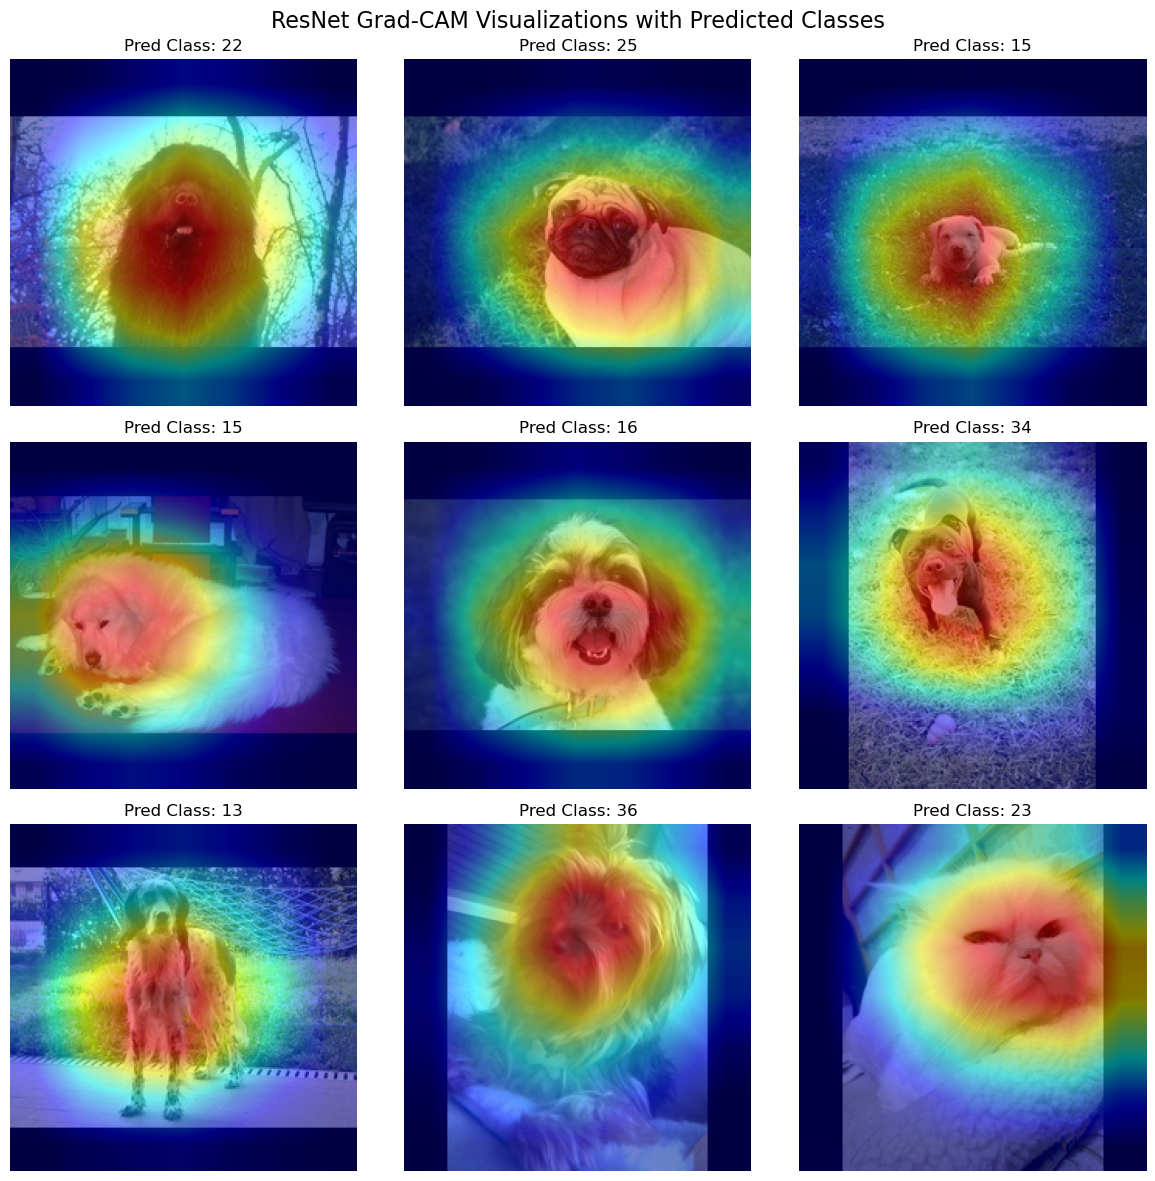

In [86]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("ResNet Grad-CAM Visualizations with Predicted Classes", fontsize=16)

for idx, ax in enumerate(axes.flat):
    img = dataset['test'][idx]['image']
    cam_image, pred_class = resnet_generate_gradcam(model = resnet, img = img)
    ax.imshow(cam_image)
    ax.set_title(f"Pred Class: {pred_class}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [108]:
def get_bounding_boxes_from_cam(grayscale_cam, threshold=0.4):
    """
    Args:
        grayscale_cam (np.array): 2D CAM heatmap in range [0, 1]
        threshold (float): Minimum activation value to consider (0.3 is a good default)

    Returns:
        List of bounding boxes [x, y, w, h]
    """
    # Normalize and threshold the heatmap
    heatmap = (grayscale_cam * 255).astype(np.uint8)
    _, binary_mask = cv2.threshold(heatmap, int(threshold * 255), 255, cv2.THRESH_BINARY)

    # Find contours from the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding boxes for each contour
    bboxes = [cv2.boundingRect(cnt) for cnt in contours]  # Returns (x, y, w, h)

    return bboxes


In [88]:
def draw_bboxes_on_image(image_np, bboxes, color=(255, 0, 0), thickness=2):
    image_copy = (image_np * 255).astype(np.uint8).copy() if image_np.max() <= 1.0 else image_np.copy()

    # Ensure it's a list of bboxes
    if isinstance(bboxes[0], (int, float)):
        bboxes = [bboxes]

    for (x, y, w, h) in bboxes:
        cv2.rectangle(image_copy, (int(x), int(y)), (int(x + w), int(y + h)), color, thickness)
    return image_copy

In [89]:
def resnet_generate_gradcam_with_bboxes(model, img, threshold = 0.4):
    input_tensor = transform(img).unsqueeze(0)
    target_layer = model.layer4[-1]
    cam = GradCAM(model=model, target_layers=[target_layer])
    outputs = model(input_tensor)
    pred_class = outputs.argmax().item()
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0, :]
    bboxes = get_bounding_boxes_from_cam(grayscale_cam, threshold=threshold)
    return grayscale_cam, pred_class, bboxes

In [81]:
dataset['test'][0]

{'image_id': 'newfoundland_31',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label_cat_dog': 'dog',
 'label_breed': 'newfoundland',
 'caption_enriched': 'a large black dog standing on a rock',
 'label_bbox_enriched': [{'bbox': [2, 1, 498, 331], 'label': 'tree'},
  {'bbox': [136, 38, 239, 296], 'label': 'dog'}],
 'issues': [],
 'bbox': [60.928000000000004, 54.024, 107.072, 132.608]}

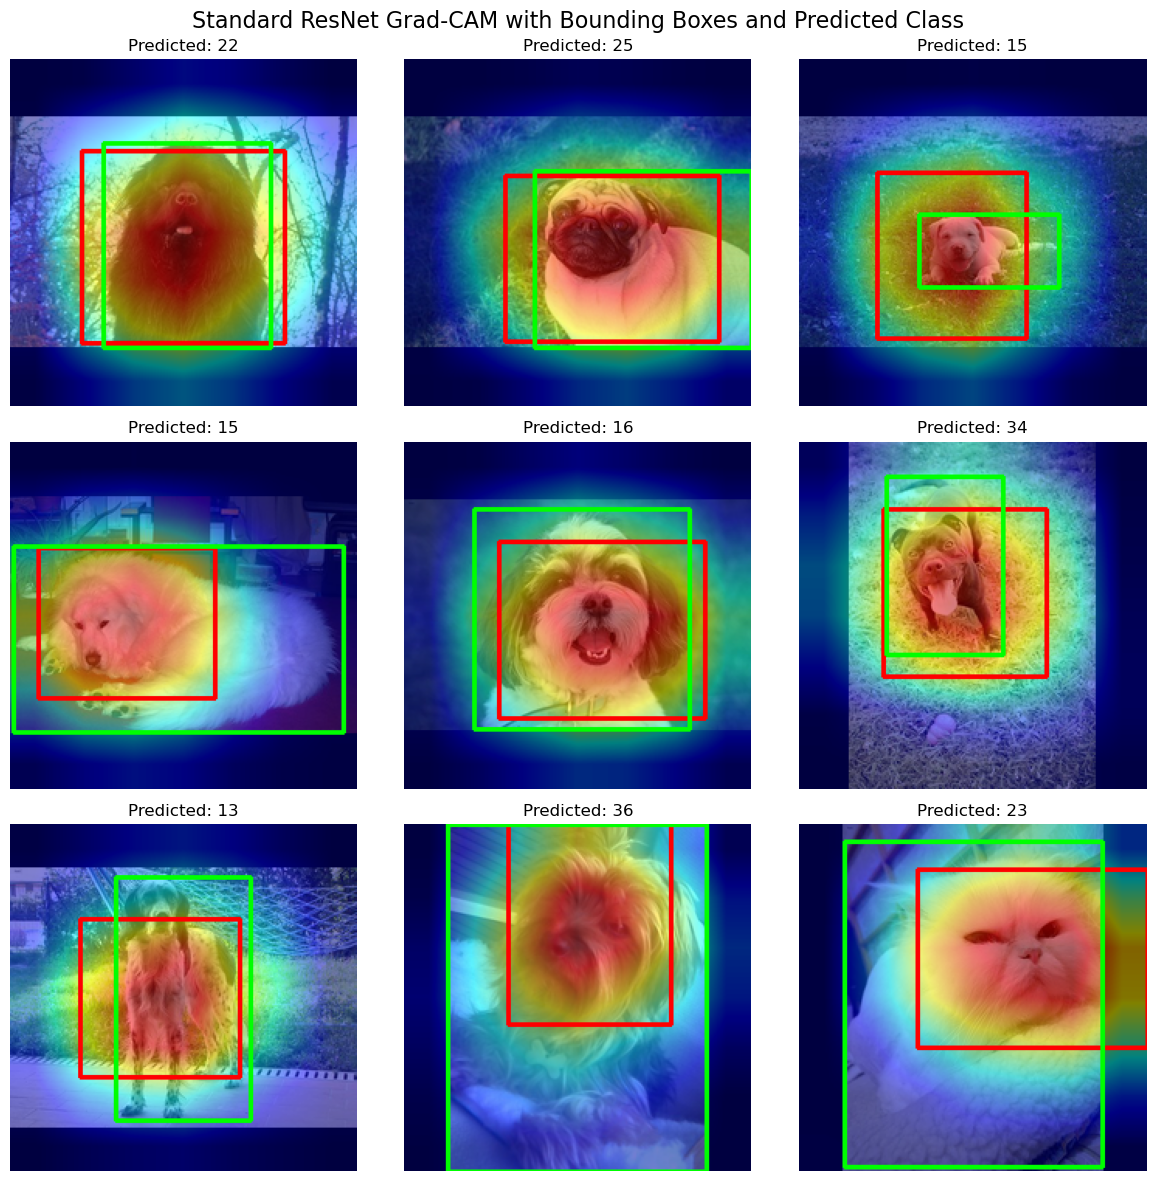

In [126]:
# 3x3 grid of images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Standard ResNet Grad-CAM with Bounding Boxes and Predicted Class", fontsize=16)

for idx, ax in enumerate(axes.flat):
    img = dataset['test'][idx]['image']  # PIL image
    img_np = np.array(img.resize((224, 224))).astype(np.float32) / 255
    true_bbox = dataset['test'][idx]['bbox']
    # Get CAM with bounding boxes
    grayscale_cam, pred_class, bboxes = resnet_generate_gradcam_with_bboxes(resnet, img, threshold=0.6)
    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    cam_boxed = draw_bboxes_on_image(image_np = cam_image, bboxes = bboxes)
    truth_and_cam_boxed = draw_bboxes_on_image(image_np = cam_boxed, bboxes = true_bbox, color = (0, 255, 0))
    ax.imshow(truth_and_cam_boxed)
    ax.set_title(f"Predicted: {pred_class}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
results = []

for i in tqdm(range(len(dataset['test']))):
    entry = dataset['test'][i]
    img_id = entry['image_id']
    img = entry['image']  # PIL
    true_bbox = entry['bbox']  # [x, y, w, h]

    grayscale_cam, pred_class, cam_bboxes = resnet_generate_gradcam_with_bboxes(resnet, img, threshold=0.4)

    # Save all data
    results.append({
        'index': img_id,
        'pred_class': pred_class,
        'true_bbox': true_bbox,
        'cam_bboxes': cam_bboxes,  # list of [x, y, w, h]
    })

# Create DataFrame
resnet_df = pd.DataFrame(results)

100%|██████████| 3511/3511 [04:07<00:00, 14.17it/s]


In [96]:
from collections import Counter
lengths = resnet_df['cam_bboxes'].apply(len)
length_counts = Counter(lengths)
length_counts_df = pd.DataFrame.from_dict(length_counts, orient='index', columns=['count']).sort_index()
print(length_counts_df)

   count
1   3511


In [ ]:
resnet_df['cam_bboxes'] = resnet_df['cam_bboxes'].apply(lambda x: list(x[0]))
resnet_df.rename(columns={'cam_bboxes': 'resnet_bbox'}, inplace=True)

In [133]:
def compute_iou(boxA, boxB):
    # box format: [x, y, w, h]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0.0
    return iou

def row_iou(row):
    return compute_iou(row['cam_bboxes'], row['true_bbox'])

In [ ]:
resnet_df['iou'] = resnet_df.apply(row_iou, axis=1)

In [107]:
print(f"ResNet mean IoU: ", resnet_df['resnet_iou'].mean())

ResNet mean IoU:  0.5660700776984707


In [106]:
resnet_df.to_csv("resnet_gradcam_results.csv", index = False)

In [109]:
# Step 1: Create the base model
resnet_adv = models.resnet18(pretrained=False)  
num_ftrs = resnet_adv.fc.in_features
resnet_adv.fc = nn.Linear(num_ftrs, 37)  # 37 breeds in the Oxford-IIIT Pet dataset

# Step 2: Load the trained weights
state_dict = torch.load("trained_models/resnet_adv.pt", map_location='cpu')
resnet_adv.load_state_dict(state_dict)
resnet_adv.eval()

/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

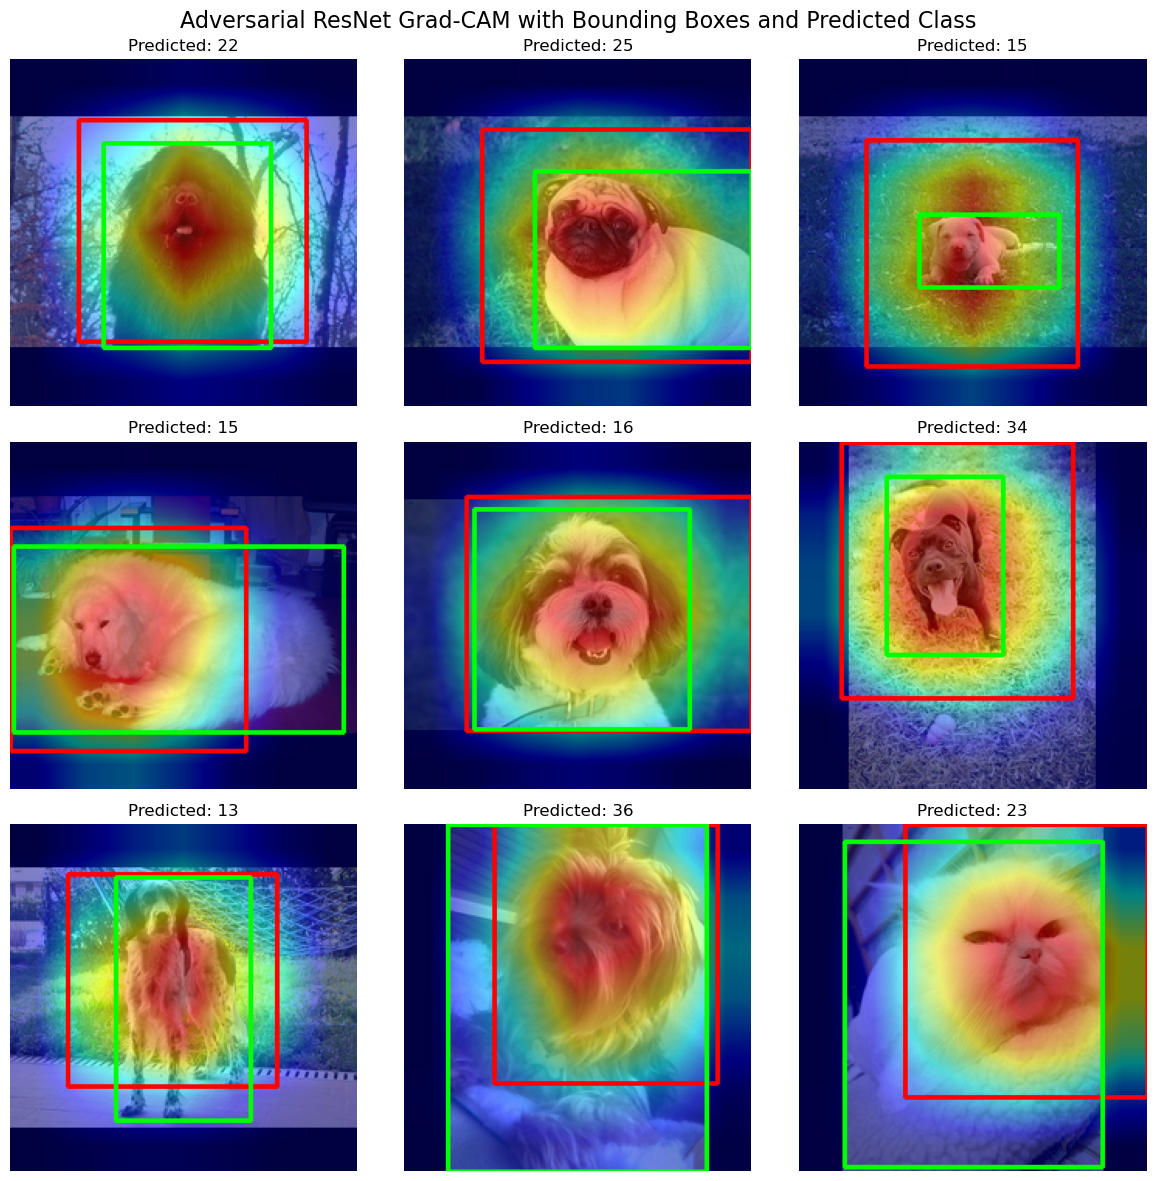

In [110]:
# 3x3 grid of images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Adversarial ResNet Grad-CAM with Bounding Boxes and Predicted Class", fontsize=16)

for idx, ax in enumerate(axes.flat):
    img = dataset['test'][idx]['image']  # PIL image
    img_np = np.array(img.resize((224, 224))).astype(np.float32) / 255
    true_bbox = dataset['test'][idx]['bbox']
    # Get CAM with bounding boxes
    grayscale_cam, pred_class, bboxes = resnet_generate_gradcam_with_bboxes(resnet_adv, img, threshold=0.4)
    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    cam_boxed = draw_bboxes_on_image(image_np = cam_image, bboxes = bboxes)
    truth_and_cam_boxed = draw_bboxes_on_image(image_np = cam_boxed, bboxes = true_bbox, color = (0, 255, 0))
    ax.imshow(truth_and_cam_boxed)
    ax.set_title(f"Predicted: {pred_class}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [111]:
results = []

for i in tqdm(range(len(dataset['test']))):
    entry = dataset['test'][i]
    img_id = entry['image_id']
    img = entry['image']  # PIL
    true_bbox = entry['bbox']  # [x, y, w, h]

    grayscale_cam, pred_class, cam_bboxes = resnet_generate_gradcam_with_bboxes(resnet_adv, img, threshold=0.4)

    # Save all data
    results.append({
        'index': img_id,
        'pred_class': pred_class,
        'true_bbox': true_bbox,
        'cam_bboxes': cam_bboxes,  # list of [x, y, w, h]
    })

# Create DataFrame
resnet_adv_df = pd.DataFrame(results)

100%|██████████| 3511/3511 [04:04<00:00, 14.35it/s]


In [112]:
resnet_adv_df['cam_bboxes'] = resnet_adv_df['cam_bboxes'].apply(lambda x: list(x[0]))
resnet_adv_df.rename(columns={'cam_bboxes': 'resnet_adv_bbox'}, inplace=True)

In [121]:
def resnet_adv_row_iou(row):
    return compute_iou(row['resnet_adv_bbox'], row['true_bbox'])

resnet_adv_df['resnet_adv_iou'] = resnet_adv_df.apply(resnet_adv_row_iou, axis=1)

In [123]:
print(f"Adversarial ResNet mean IoU: ", resnet_adv_df['resnet_adv_iou'].mean())

Adversarial ResNet mean IoU:  0.5663397923732733


In [ ]:
def generate_gradcam_df(model, dataset, threshold=0.4):
    """
    Runs Grad-CAM on a model and collects predicted and ground truth bboxes.

    Args:
        model: PyTorch model
        dataset: Dataset dictionary with 'test' split containing 'image', 'bbox', 'image_id'
        threshold: Grad-CAM activation threshold for bbox extraction

    Returns:
        pd.DataFrame with columns: index (image_id), pred_class, true_bbox, cam_bboxes
    """
    results = []

    model.eval()

    for i in tqdm(range(len(dataset['test'])), desc="Generating Grad-CAM DataFrame"):
        entry = dataset['test'][i]
        img_id = entry['image_id']
        img = entry['image']  # PIL
        true_bbox = entry['bbox']  # [x, y, w, h]

        grayscale_cam, pred_class, cam_bboxes = resnet_generate_gradcam_with_bboxes(
            model, img, threshold=threshold
        )

        results.append({
            'index': img_id,
            'pred_class': pred_class,
            'true_bbox': true_bbox,
            'cam_bboxes': cam_bboxes,
        })

    return pd.DataFrame(results)

In [131]:
resnet_06 = generate_gradcam_df(model = resnet, dataset = dataset, threshold=0.6)

Generating Grad-CAM DataFrame: 100%|██████████| 3511/3511 [03:32<00:00, 16.53it/s]


In [ ]:
resnet_06['cam_bboxes'] = resnet_06['cam_bboxes'].apply(lambda x: list(x[0]))


In [135]:
resnet_06['iou'] = resnet_06.apply(row_iou, axis=1)

In [137]:
print(f"ResNet mean IoU with threshold at 0.6: ", resnet_06['iou'].mean())

ResNet mean IoU with threshold at 0.6:  0.5163739017184787


In [140]:
resnet_06.to_csv("resnet_06.csv", index=False)

In [139]:
resnet_adv_06 = generate_gradcam_df(model = resnet_adv, dataset = dataset, threshold=0.6)
resnet_adv_06['cam_bboxes'] = resnet_adv_06['cam_bboxes'].apply(lambda x: list(x[0]))
resnet_adv_06['iou'] = resnet_adv_06.apply(row_iou, axis=1)
print(f"Adversarial ResNet mean IoU with threshold at 0.6: ", resnet_adv_06['iou'].mean())

Generating Grad-CAM DataFrame: 100%|██████████| 3511/3511 [03:37<00:00, 16.13it/s]

Adversarial ResNet mean IoU with threshold at 0.6:  0.49646004844800645
